# Réseau Neuronal Convolutif (CNN) avec Transfer Learning

Votre entreprise souhaite améliorer sa plateforme avec une nouvelle fonctionnalité de collaboration. Les utilisateurs pourront par exemple poster des avis et des photos sur leur restaurant préféré. Ce sera aussi l’occasion, pour l’entreprise, de mieux comprendre les avis postés par les utilisateurs.

**Objectif** : Labelliser automatiquement les photos postées sur la plateforme. Par exemple, identifier les photos relatives à la nourriture, au décor dans le restaurant ou à l’extérieur du restaurant.

# Sommaire

 1. [Chargement des bibliothèques](#load-lib)
 2. [Chargement des données](#load-data)
	1. [Sélection d'un échantillon](#select-sample)
    2. [Création des data frame](#create-df)
 3. [Préparation des données](#prepare-photos)
 4. [Définition du modèle](#cnn-model)
 5. [Entrainement du modèle](#train-model)
 6. [Performances du modèle](#pref-model)
 7. [Prédictions](#predict)
 8. [Conclusion](#conclusion)

# Chargement des bibliothèques <a class="anchor" id="load_lib"></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
from sklearn import cluster, metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.image import imread

Using TensorFlow backend.


In [2]:
datafile = '../data/photos.json'
img_dir = '../data/photos/'
img_clean_dir = '../data/clean_photos/'
outputfile = '../data/clean_photos.csv'
outputfile_raw = '../data/raw_photos.csv'
chunksize = 10000

# Chargement des données <a class="anchor" id="load_data"></a>

In [3]:
# Load data
data = pd.read_csv('../data/clean_photos.csv')
data.head()

,photo_id,label
0,Un_Og6jfhazVn7CxszkKEw,drink
1,BFE1AFOs27scnnfeBf99ZA,drink
2,7t-C0r1JRdoVD9FS7M-N7Q,drink
3,rLnw0d-YYZvT9kR4y7h7_Q,drink
4,Cv5M8MDw8a5NEWvw2AQ4nw,drink


## Sélection d'un échantillon <a class="anchor" id="select_sample"></a>
Nous allons sélectionner un échantillon de données équivalent dans chaque categories. Nous utiliserons 5000 images au total qui seront réparties en 3500 images pour l'entrainement, 900 images pour la validation et 600 images pour les tests.

In [4]:
# Get sample of data with same number of photos in each categories
n_sample = 1000
df_drink = data[data['label'] == 'drink'].sample(n=n_sample)
df_menu = data[data['label'] == 'menu'].sample(n=n_sample)
df_interior = data[data['label'] == 'interior'].sample(n=n_sample)
df_outside = data[data['label'] == 'outside'].sample(n=n_sample)
df_food = data[data['label'] == 'food'].sample(n=n_sample)

data = pd.concat([df_drink, df_menu, df_interior,df_outside, df_food ], ignore_index=True)

In [5]:
# Add file extenion to photos
data['photo_id'] = data['photo_id'].apply(lambda x: x + '.jpg')

## Création  des data frame (train, val et test) <a class="anchor" id="load_lib"></a>

In [6]:
# Set train and test set
X_train, X_test, y_train, y_test = train_test_split(data['photo_id'], data['label'], test_size=0.20, random_state=63)

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.10, random_state=63)

In [8]:
print(f"{X_train.shape} enregistrement pour l'entrainement")
print(f"{X_val.shape} enregistrement pour la validation")
print(f"{X_test.shape} enregistrement pour les test")

(4000,) enregistrement pour l'entrainement
(900,) enregistrement pour la validation
(100,) enregistrement pour les test


In [9]:
# set train and test data frame
train_df = pd.DataFrame({ 'photo_id': X_train, 'label': y_train })
val_df = pd.DataFrame({ 'photo_id': X_val, 'label': y_val })
test_df = pd.DataFrame({ 'photo_id': X_test, 'label': y_test })

# Préparation des images <a class="anchor" id="prepare-photos"></a>
La préparation des images consiste à normaliser les images au niveau des pixels et à fixer leur dimension (224x224 pixels)

In [10]:
batch_size=64
img_size=(224,224)

In [11]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [12]:
train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=img_dir,
            x_col="photo_id",
            y_col="label",
            has_ext=True,      
            image_size=img_size,
            batch_size=batch_size,
            seed=63,
            shuffle=True,
            class_mode="categorical",
            classes=['drink', 'menu', 'interior', 'outside', 'food'],
            target_size=(img_size))

Found 4000 validated image filenames belonging to 5 classes.


In [13]:
val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_df,
            directory=img_dir,
            x_col="photo_id",
            y_col="label",
            has_ext=True,      
            image_size=img_size,
            batch_size=batch_size,
            seed=63,
            shuffle=True,
            class_mode="categorical",
            classes=['drink', 'menu', 'interior', 'outside', 'food'],
            target_size=(img_size))

Found 900 validated image filenames belonging to 5 classes.


In [14]:
test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=img_dir,
            x_col="photo_id",
            y_col="label",
            has_ext=True,            
            batch_size=test_df.shape[0],
            image_size=img_size,
            seed=63,
            shuffle=False,
            class_mode="categorical",
            classes=['drink', 'menu', 'interior', 'outside', 'food'],
            target_size=(img_size))

Found 100 validated image filenames belonging to 5 classes.


# Définition du modèle <a class="anchor" id="cnn-model"></a>
Nous avons choisi un réseau à convolution, dont la première partie est un modèle déjà entrainé. Nous remplacerons la dernière couche par une vectorisatuin, puis couche totalement connectée et enfin une couche de sortie avec 5 catégories 

In [15]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
    
# Marque les couches chargées comme non entrainable
for layer in model.layers:
    layer.trainable = False
    
# Ajout des nouvelles couches
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(5, activation='softmax')(class1)
    
# Définition du nouveau modèle
model = Model(inputs=model.inputs, outputs=output)
    
# compililation du nouveau modèle
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Entrainement du modèle <a class="anchor" id="train-model"></a>
Pour l'entrainement du modèle nous avons choisi d'entrainer 100 fois les données avec une mise à jour de 109 fois par époque pour le jeu d'entrainement et de 28 fois pour le jeu de validation. 

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

nb_epoch = 100

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=nb_epoch
)

Epoch 1/100
62/62 [==============================] - 502s 8s/step - loss: 0.8642 - accuracy: 0.6570 - val_loss: 0.6637 - val_accuracy: 0.7288
Epoch 2/100
62/62 [==============================] - 501s 8s/step - loss: 0.4673 - accuracy: 0.8305 - val_loss: 0.4746 - val_accuracy: 0.8225
Epoch 3/100
62/62 [==============================] - 505s 8s/step - loss: 0.4595 - accuracy: 0.8163 - val_loss: 0.4580 - val_accuracy: 0.8382
Epoch 4/100
62/62 [==============================] - 507s 8s/step - loss: 0.3459 - accuracy: 0.8770 - val_loss: 0.4526 - val_accuracy: 0.8415
Epoch 5/100
62/62 [==============================] - 492s 8s/step - loss: 0.3364 - accuracy: 0.8768 - val_loss: 0.5496 - val_accuracy: 0.7969
Epoch 6/100
62/62 [==============================] - 479s 8s/step - loss: 0.3093 - accuracy: 0.8863 - val_loss: 0.4441 - val_accuracy: 0.8371
Epoch 7/100
62/62 [==============================] - 474s 8s/step - loss: 0.2596 - accuracy: 0.9126 - val_loss: 0.4207 - val_accuracy: 0.8438
Epoch 

In [17]:
# Save model
model.save("cnn_vgg16_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_vgg16_model/assets


## Performances du modèle <a class="anchor" id="pref_model"></a>

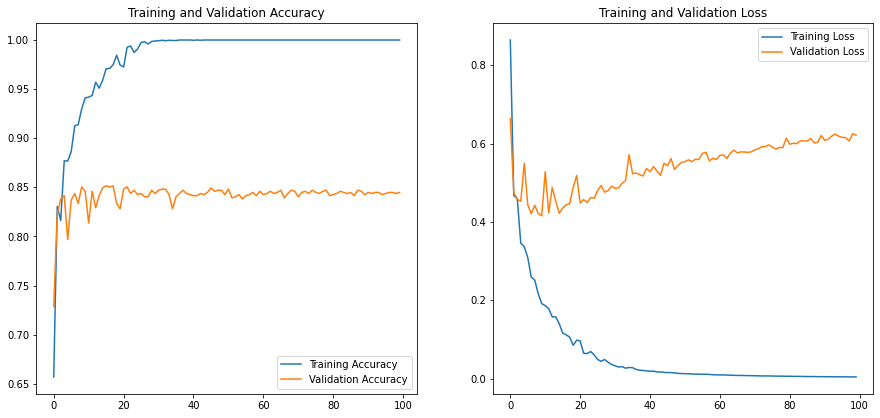

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(nb_epoch)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prédictions
Le jeu de données de test, va nous permettre de tester notre modèle avec des données complètement nouvelles pour le modèle.

In [19]:
test_generator.reset()
pred = model.predict(test_generator,verbose=1)

1/1 [==============================] - 0s 1ms/step


In [20]:
_, acc = model.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f'Précision > {acc * 100.0:.3f} %')

Précision > 86.000 %


In [21]:
predictions=[]
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred:
    index = row.argmax()       
    predictions.append(labels[index])

filenames=test_generator.filenames

results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                      "labels": test_generator.labels
                     })

In [22]:
results['labels'] = results['labels'].map(labels)

In [23]:
conf_mat = metrics.confusion_matrix(results['Predictions'], results['labels'])

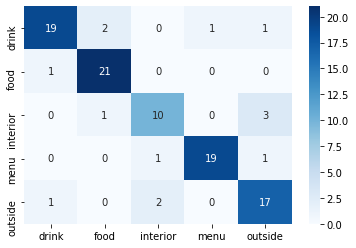

In [24]:
inv_labels = {v: k for k, v in labels.items()}
df_cm = pd.DataFrame(conf_mat, index = [label for label in inv_labels],columns = inv_labels)
sns.heatmap(df_cm, annot=True, cmap="Blues")

Le modèle semble avoir plus de difficultés à déterminer si une image est en intérieur ou en extérieur.

# Prédiction d'une image

,0
Boisson,0
Nourriture,0
Intérieur,1
Menu,0
Extérieur,0


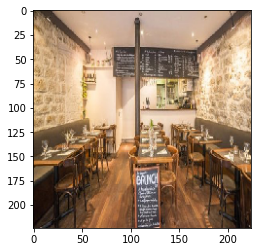

In [51]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

filename = 'interieur-restaurant.jpg'
image = load_img(filename, target_size=(224, 224))
plt.imshow(image)

# convert to array
image = img_to_array(image)

# reshape into a single sample with 3 channels
image = image.reshape(1, 224, 224, 3)


# Traitement de l'image
result = model.predict(image)


pred=pd.DataFrame(result.astype(int))
pred.columns = ['Boisson', 'Nourriture', 'Intérieur', 'Menu','Extérieur']

display(pred.T)

# Conclusion
Ce modèle avec des couches déjà éntrainées donnent de très bonnes performances et sont taux de précision de 85% en atteste. Pour augmenter sa précision, une solution serait d'aintriner le modèle avec plus d'images.
